In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random, copy
import torch
from collections import deque

In [2]:
import gym
env = gym.make("MountainCar-v0")

In [3]:
# a model to approximate Q function
class QApproximation:
    def __init__(self, env, hidden_sz=32, max_eps=1.0, min_eps=0.1, eps_decrease_rate=0.99):
        self.actions_n = env.action_space.n
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(env.observation_space.shape[0], hidden_sz),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_sz, hidden_sz),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_sz, self.actions_n)
        )
        self.nn.train()
        
        # constants for epsilon in eps-greedy policy
        self.max_eps = max_eps
        self.min_eps = min_eps
        self.eps_decrease_rate = eps_decrease_rate
        self.eps = self.max_eps
    
    def predict(self, state):
        return self.nn(torch.tensor(state).float().unsqueeze(0)).detach()
    
    def max_policy(self, state):
        return np.argmax(self.predict(state)).item()
    
    def eps_greedy_policy(self, state):
        self.eps = max(self.min_eps, self.eps * self.eps_decrease_rate)
        if random.random() < self.eps:
            return np.random.choice(self.actions_n)
        return self.max_policy(state)


q = QApproximation(env)

In [4]:
class Memory:
    def __init__(self, max_sz):
        self.max_sz = max_sz
        self.mem = deque([])

    def __len__(self):
        return len(self.mem)

    def append(self, x):
        self.mem.append(x)
        if len(self.mem) > self.max_sz:
            self.mem.popleft()

    def random_sample(self, sz):
        return random.sample(self.mem, sz)

In [5]:
optimizer = torch.optim.Adam(q.nn.parameters(), lr=0.00005)

In [6]:
def fit(states, actions, next_states, rewards, gamma=0.99):
    # fit the model to approximate Q function using the given batch
    q_prediction = q.nn(torch.FloatTensor(states)).gather(1, torch.LongTensor(actions).unsqueeze(1))
    q_target = torch.FloatTensor(rewards) + gamma * q.nn(torch.FloatTensor(next_states)).max(1)[0].detach()
    loss = torch.nn.functional.smooth_l1_loss(q_prediction, q_target.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    for p in q.nn.parameters():
        p.grad.data.clamp_(-1, 1)

In [7]:
def process_reward(state, action, new_state, reward):
    return reward + abs(new_state[1])

In [8]:
def train(episodes_n=2000, mem_sz=4000, fit_batch_sz=100):
    memory = Memory(mem_sz)
    total_rewards = []
    max_q = copy.deepcopy(q) # the best q function
    max_avg = -np.inf
    
    for episode in range(1, episodes_n+1):
        state = env.reset()
        done = False
        total_reward = 0
        while not done:
            action = q.eps_greedy_policy(state)
            new_state, reward, done, _ = env.step(action)
            total_reward += reward
            reward = process_reward(state, action, new_state, reward)
            memory.append((state, action, new_state, reward))
            state = new_state
            
            if len(memory) >= fit_batch_sz:
                batch = memory.random_sample(fit_batch_sz)
                states, actions, next_states, rewards = tuple([[b[i] for b in batch] for i in range(4)])
                fit(states, actions, next_states, rewards)

        total_rewards.append(total_reward)
            
        if episode % 10 == 0:
            avg = np.mean(total_rewards[-10:])
            print("\rEpisode {} out of {}, average total reward {}".format(
                episode, episodes_n, avg), end="")
            if avg > max_avg:
                max_avg = avg
                max_q = copy.deepcopy(q)
        
        if 2 * episode >= episodes_n:
            optimizer = torch.optim.Adam(q.nn.parameters(), lr=0.00001)

    return max_q, total_rewards

Episode 2000 out of 2000, average total reward -196.8

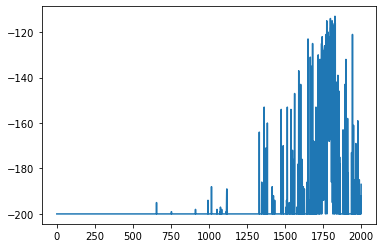

In [9]:
max_q, total_rewards = train()
plt.plot(total_rewards)

In [14]:
state = env.reset()
total_reward = 0
done = False
while not done:
    action = max_q.max_policy(state)
    env.render()
    state, reward, done, _ = env.step(action)
    total_reward += reward
print('Final total reward:', total_reward)
env.close()

torch.save(max_q.nn.state_dict(), 'MountainCarModel.h5')

Final total reward: -116.0
